
split data --- start
split data --- end

feature extraction --- start
feature extraction --- end

latent semantic analysis --- start
latent semantic analysis --- end

build and predict --- start
build and predict --- end


Model Evaluation:
Performance Metrics:
|         |   accuracy |   precision |   recall |    f1 |
|---------|------------|-------------|----------|-------|
| metrics |      0.812 |       0.719 |    0.695 | 0.706 |


<Figure size 640x480 with 0 Axes>

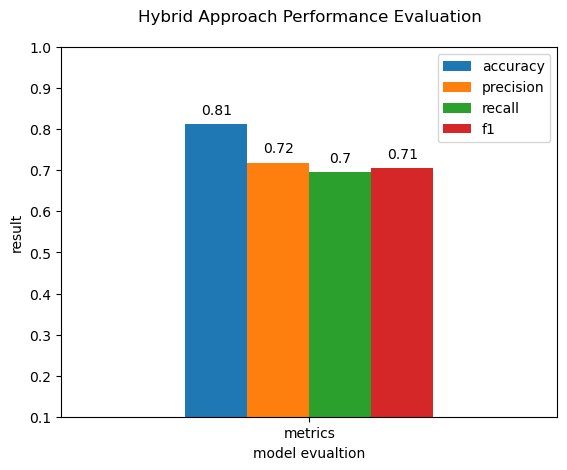


Confusion Matrix of Hybrid Approach:



C:\Users\Microsoft\AppData\Local\Temp\ipykernel_4764\4019642764.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\Microsoft\AppData\Local\Temp\ipykernel_4764\4019642764.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


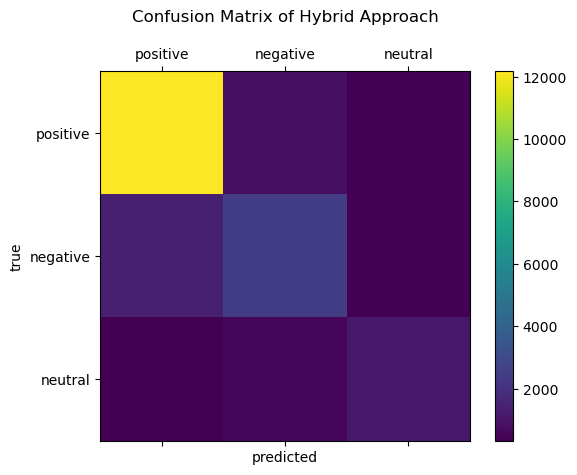

                 predicted:                 
                   positive negative neutral
actual: positive      12185      800     347
        negative       1352     2485     331
        neutral         335      485    1107

Classification Report of Hybrid Approach to Sentiment Analysis:

              precision    recall  f1-score   support

    positive       0.88      0.91      0.90     13332
    negative       0.66      0.60      0.63      4168
     neutral       0.62      0.57      0.60      1927

    accuracy                           0.81     19427
   macro avg       0.72      0.69      0.71     19427
weighted avg       0.81      0.81      0.81     19427




In [2]:
"""

Hybrid approach for sentiment analysis. It is the combination of lexicon-based technique and machine learning technique
to perform sentiment analysis.

"""

# import module
import numpy as np
import pandas as pd
import sklearn.metrics as mt
from tabulate import tabulate
from sklearn.svm import LinearSVC
import sklearn.model_selection as ms
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# load data
filename = r'C:\Users\Microsoft\Documents\sentiment-analysis\sentiment-analysis\sentiment-analysis\datasets\amazon_unlocked_mobile_datasets_with_sentiment\amazon_unlocked_mobile_datasets_with_sentiment.csv'
names = ['product.name', 'brand.name', 'review.text', 'review.process', 'review.tokened', 'score', 'sentiment']
fields = ['review.tokened', 'sentiment']
review = pd.read_csv(filename, names=names, usecols=fields)

print()

# split data 70% train 30% test
print('split data --- start')
array = review.values
X = array[:, 0:1]
Y = array[:, 1]
size = 0.3

# testX and trainX is review.tokened
# testY and trainY is sentiment
trainX, testX, trainY, testY = ms.train_test_split(X, Y, test_size=size, shuffle=True)
print('split data --- end')

print()

# feature extraction
print('feature extraction --- start')
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1, 2), sublinear_tf=False,
                     max_features=10000, smooth_idf=True, stop_words='english')
tv_train = tv.fit_transform(trainX.ravel())
tv_test = tv.transform(testX.ravel())  # transform test review into features
print('feature extraction --- end')

print()

# latent semantic analysis on train data (lexicon based)
print('latent semantic analysis --- start')
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_train = lsa.fit_transform(tv_train)
lsa_test = lsa.transform(tv_test)  # transform tfidf test
print('latent semantic analysis --- end')

print()

# build model and predict with lsa train (machine learning)
print('build and predict --- start')
svm = LinearSVC()
svm.fit(lsa_train, trainY)
svm_pred = svm.predict(lsa_test)
print('build and predict --- end')

print()

# evaluation
print('\nModel Evaluation:')
svm_accuracy = np.round(mt.accuracy_score(testY, svm_pred), 3)
svm_precision = np.round(mt.precision_score(testY, svm_pred, average='macro'), 3)
svm_recall = np.round(mt.recall_score(testY, svm_pred, average='macro'), 3)
svm_f1 = np.round(mt.f1_score(testY, svm_pred, average='macro'), 3)

svm_metrics = np.array([svm_accuracy, svm_precision, svm_recall, svm_f1])
svm_metrics = pd.DataFrame([svm_metrics], columns=['accuracy', 'precision', 'recall', 'f1'], index=['metrics'])
print('Performance Metrics:')
print(tabulate(svm_metrics, headers='keys', tablefmt='github'))

# visualization
# reference: https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
fig = plt.figure()
ax = svm_metrics.plot.bar()
plt.title('Hybrid Approach Performance Evaluation\n')
plt.ylabel('result')
plt.xlabel('model evualtion')
plt.xticks(rotation=-360)  # rotate x labels
plt.ylim([0.1, 1.0])
for item in ax.patches:  # show value on plot
    ax.annotate(np.round(item.get_height(), decimals=2), (item.get_x() + item.get_width() / 2., item.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.savefig('../results/hybrid_performance.png', format='png', transparent=False)  # save result
plt.show()

print('\nConfusion Matrix of Hybrid Approach:\n')

# display and plot confusion matrix
labels = ['positive', 'negative', 'neutral']
svm_cm = mt.confusion_matrix(testY, svm_pred, labels=labels)

# plot
# display and plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Confusion Matrix of Hybrid Approach\n')
fig.colorbar(ax.matshow(svm_cm))
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('predicted')
plt.ylabel('true')
plt.savefig('../results/hybrid_confusion_matrix.png',  format='png', transparent=False)  # save result
plt.show()

# display in table format
level = [len(labels)*[0], list(range(len(labels)))]
svm_cmf = pd.DataFrame(data=svm_cm,
                       columns=pd.MultiIndex(levels=[['predicted:'], labels], codes=level),
                       index=pd.MultiIndex(levels=[['actual:'], labels], codes=level))
print(svm_cmf)

print('\nClassification Report of Hybrid Approach to Sentiment Analysis:\n')

# classification report for hybrid approach
svm_report = mt.classification_report(testY, svm_pred, labels=labels)
print(svm_report)

print()

# output performance to csv
svm_metrics.to_csv('../results/hybrid_performance_result.csv', index=None, header=True)

# end of hybrid approach
